<a href="https://colab.research.google.com/github/indiradrr/VariationalAutoencoder/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os


In [ ]:

class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
        self.folder_path = folder_path
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_name).convert("L")  # Grayscale
        if self.transform:
            image = self.transform(image)
        return image


transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset_path = '/content/drive/MyDrive/keras_png_slices_data/keras_png_slices_train'
val_dataset_path = '/content/drive/MyDrive/keras_png_slices_data/keras_png_slices_validate'
test_dataset_path = '/content/drive/MyDrive/keras_png_slices_data/keras_png_slices_test'

batch_size = 128

# Create datasets
train_dataset = CustomDataset(folder_path=train_dataset_path, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize variables
mean = 0.0
std = 0.0
nb_samples = 0

# Calculate mean
for data in train_dataloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples

# Calculate std
for data in train_dataloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    std += ((data - mean.unsqueeze(1))**2).sum([0,2])

std = torch.sqrt(std / (nb_samples * 128 * 128))

print(f"Mean: {mean}")
print(f"Std: {std}")



Mean: tensor([0.1317])
Std: tensor([0.3755])


In [ ]:
transform = transforms.Compose([
    transforms.CenterCrop(210),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


train_dataset = CustomDataset(folder_path=train_dataset_path, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(folder_path=val_dataset_path, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = CustomDataset(folder_path=test_dataset_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

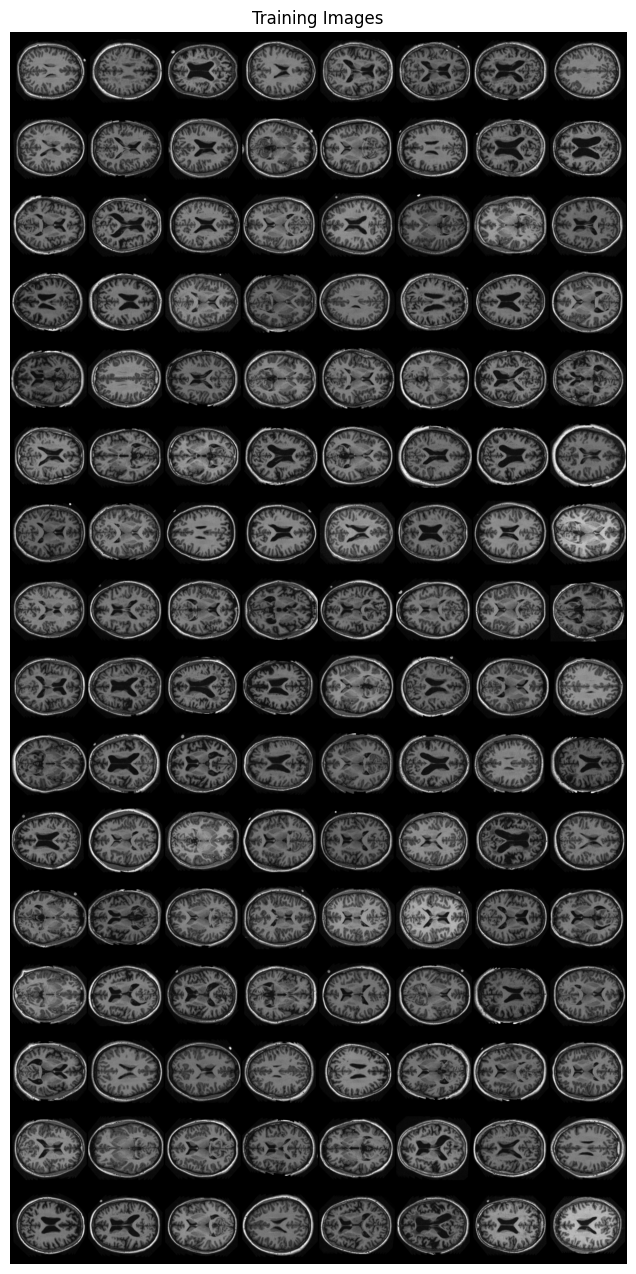

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a batch of training data
dataiter = iter(train_dataloader)
images = next(dataiter)

# Create a grid from the images
grid = vutils.make_grid(images, nrow=8, padding=2, normalize=True)

# Plot the images
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()


In [ ]:
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # B, 32, 100, 100
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # B, 64, 50, 50
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # B, 128, 25, 25
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), # B, 256, 12, 12
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1), # B, 512, 6, 6
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(6 * 6 * 512, 2 * z_dim)  # B, 2 * z_dim
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 6 * 6 * 512),
            nn.ReLU(),
            nn.Unflatten(1, (512, 6, 6)),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # B, 256, 12, 12
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # B, 128, 24, 24
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # B, 64, 48, 48
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # B, 32, 96, 96
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),  # B, 16, 192, 192
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 19, 1, 0),  # B, 1, 210, 210
            nn.Sigmoid()
        )


    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var


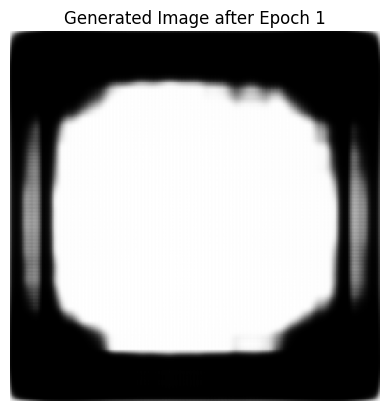

Epoch [1/10], Batch [63] - Loss: 0.1718, Recon: 0.1712, KLD: 0.0006, Time: 47.05s


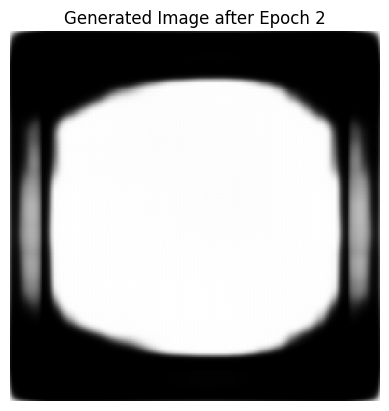

Epoch [2/10], Batch [63] - Loss: 0.1663, Recon: 0.1663, KLD: 0.0000, Time: 90.03s


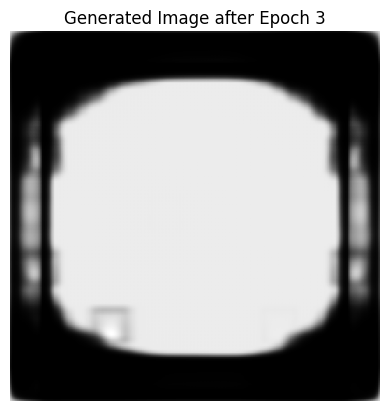

Epoch [3/10], Batch [63] - Loss: 0.1783, Recon: 0.1777, KLD: 0.0007, Time: 134.24s


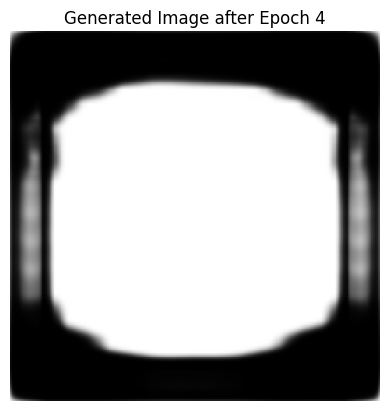

Epoch [4/10], Batch [63] - Loss: 0.1786, Recon: 0.1785, KLD: 0.0000, Time: 177.55s


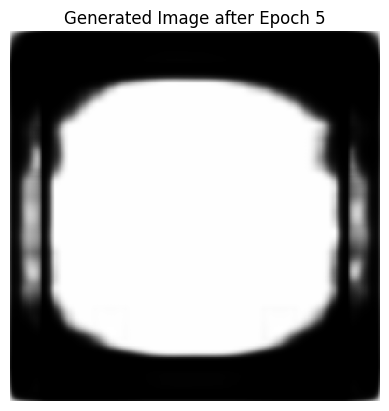

Epoch [5/10], Batch [63] - Loss: 0.1837, Recon: 0.1837, KLD: 0.0000, Time: 221.35s


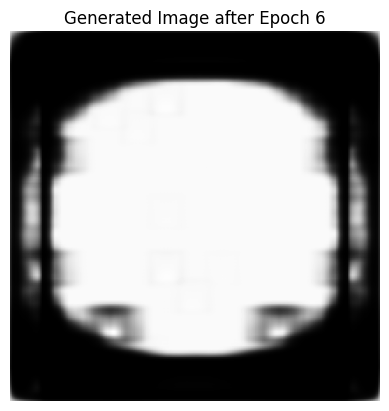

Epoch [6/10], Batch [63] - Loss: 0.1702, Recon: 0.1702, KLD: 0.0000, Time: 265.38s


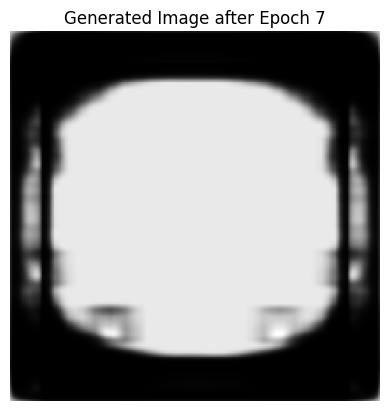

Epoch [7/10], Batch [63] - Loss: 0.1737, Recon: 0.1736, KLD: 0.0000, Time: 309.90s


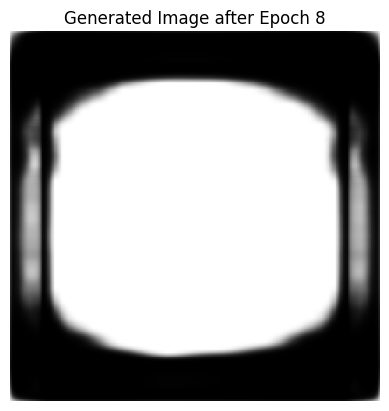

Epoch [8/10], Batch [63] - Loss: 0.1746, Recon: 0.1746, KLD: 0.0000, Time: 353.93s


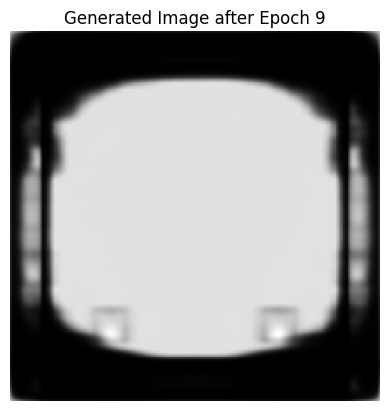

Epoch [9/10], Batch [63] - Loss: 0.1682, Recon: 0.1682, KLD: 0.0000, Time: 398.13s


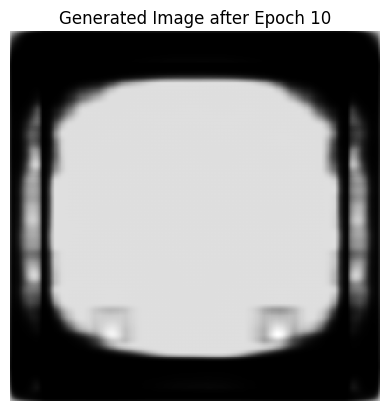

Epoch [10/10], Batch [63] - Loss: 0.1703, Recon: 0.1702, KLD: 0.0000, Time: 442.06s


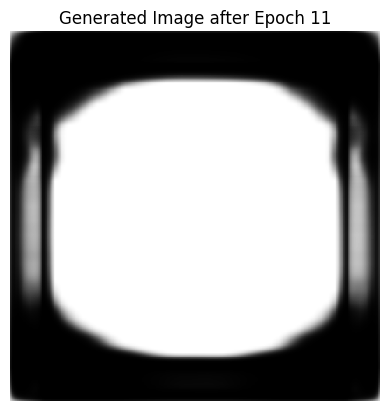

Epoch [11/10], Batch [63] - Loss: 0.1743, Recon: 0.1743, KLD: 0.0000, Time: 486.04s


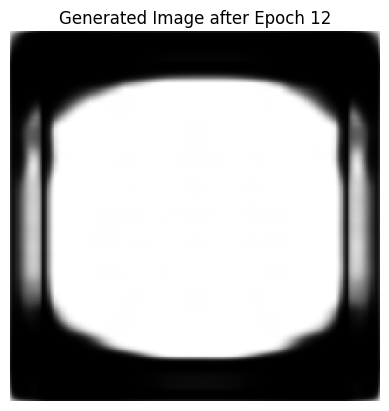

Epoch [12/10], Batch [63] - Loss: 0.1828, Recon: 0.1828, KLD: 0.0000, Time: 529.80s


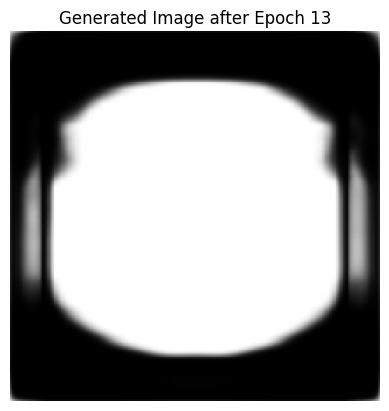

Epoch [13/10], Batch [63] - Loss: 0.1675, Recon: 0.1675, KLD: 0.0000, Time: 573.61s


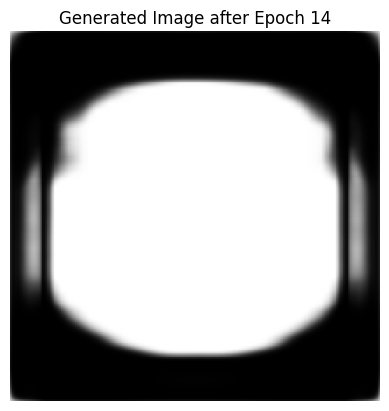

Epoch [14/10], Batch [63] - Loss: 0.1780, Recon: 0.1775, KLD: 0.0004, Time: 617.64s


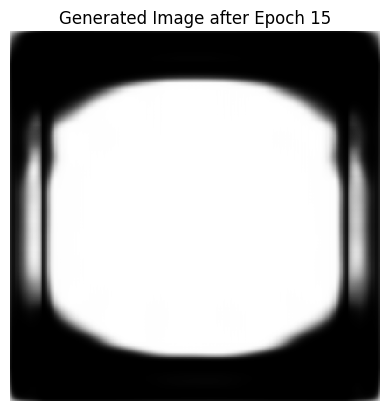

Epoch [15/10], Batch [63] - Loss: 0.1703, Recon: 0.1703, KLD: 0.0000, Time: 661.47s


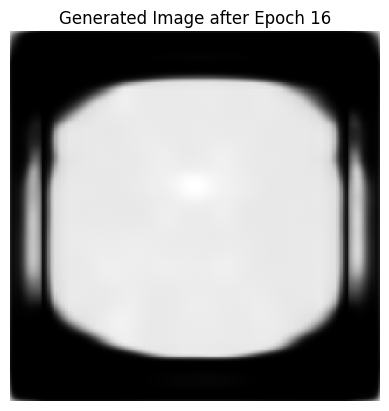

Epoch [16/10], Batch [63] - Loss: 0.1673, Recon: 0.1672, KLD: 0.0000, Time: 705.47s


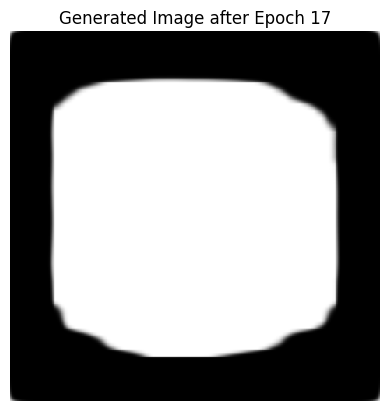

Epoch [17/10], Batch [63] - Loss: 0.1772, Recon: 0.1772, KLD: 0.0000, Time: 749.53s


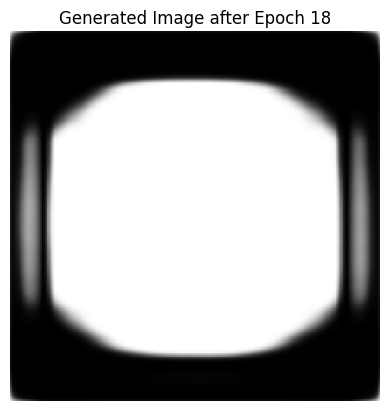

Epoch [18/10], Batch [63] - Loss: 0.1721, Recon: 0.1721, KLD: 0.0000, Time: 793.30s


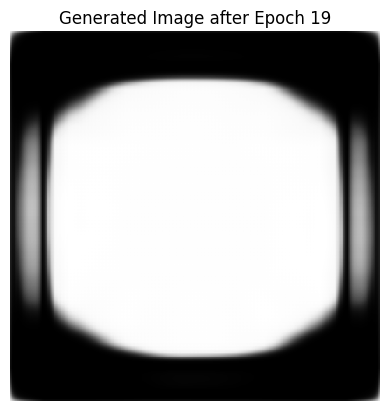

Epoch [19/10], Batch [63] - Loss: 0.1832, Recon: 0.1832, KLD: 0.0000, Time: 837.48s


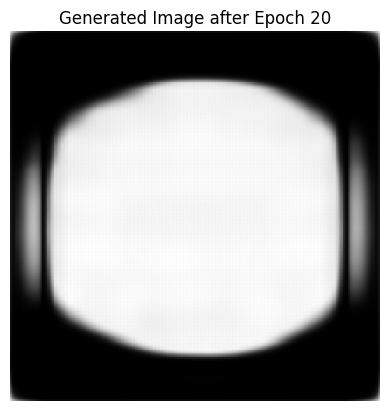

Epoch [20/10], Batch [63] - Loss: 0.1672, Recon: 0.1672, KLD: 0.0000, Time: 881.42s


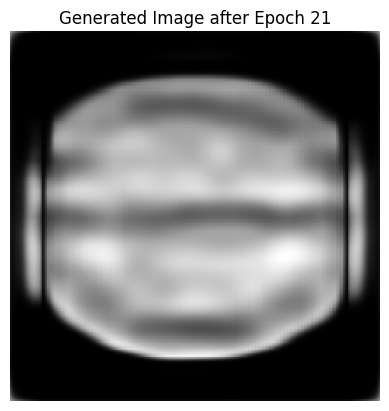

Epoch [21/10], Batch [63] - Loss: 0.1674, Recon: 0.1674, KLD: 0.0000, Time: 925.61s


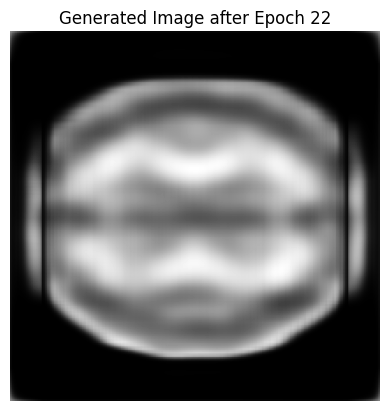

Epoch [22/10], Batch [63] - Loss: 0.1643, Recon: 0.1643, KLD: 0.0000, Time: 969.58s


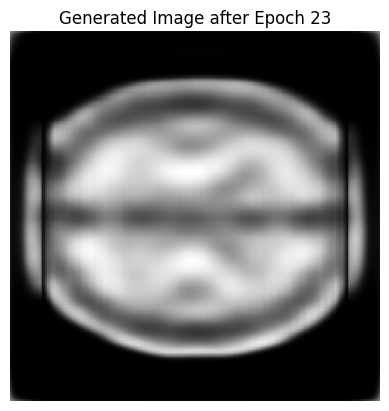

Epoch [23/10], Batch [63] - Loss: 0.1621, Recon: 0.1620, KLD: 0.0000, Time: 1013.60s


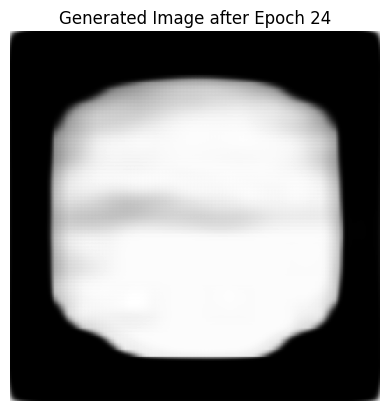

Epoch [24/10], Batch [63] - Loss: 0.1691, Recon: 0.1691, KLD: 0.0000, Time: 1057.51s


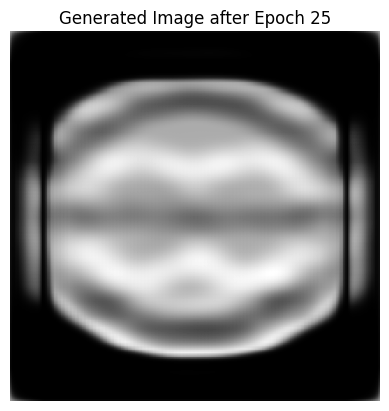

Epoch [25/10], Batch [63] - Loss: 0.1643, Recon: 0.1639, KLD: 0.0004, Time: 1101.47s


In [ ]:
import time
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
z_dim = 64
model = VAE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=0.001)

epochs = 25

# Initialize hyperparameters for balancing the losses
alpha = 5.0  # Reconstruction loss weight
beta = 1.0  # KLD loss weight

start_time = time.time()

# outer loop for tqdm to show epoch progress
for epoch in range(epochs):
    # inner loop to show batch progress within each epoch
    pbar = tqdm(enumerate(train_dataloader), desc='Batch', leave=False)
    for i, imgs in pbar:
        imgs = imgs.to(device)
        recon, mu, log_var = model(imgs)

        # Reconstruction loss
        recon_loss = nn.functional.mse_loss(recon, imgs)

        # KL divergence
        kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / (imgs.shape[0] * imgs.shape[1] * imgs.shape[2] * imgs.shape[3])


        # Total loss
        loss = recon_loss + beta * kld

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time

        # if alpha > 1.0:
        #   alpha -= 0.1
        pbar.set_description(f"Epoch [{epoch + 1}/10], Batch [{i + 1}] - Loss: {loss.item():.4f}, Recon: {recon_loss.item():.4f}, KLD: {kld.item():.4f}, Time: {elapsed_time:.2f}s")


    # # Save the model weights after each epoch
    # torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

    # Generate some images using the current model
    z = torch.randn(1, 64).to(device)

    with torch.no_grad():
        generated_image = model.decoder(z)

    # Convert the generated image to a numpy array and plot it
    generated_image_np = generated_image.cpu().squeeze().numpy()
    plt.imshow(generated_image_np, cmap='gray')
    plt.title(f"Generated Image after Epoch {epoch+1}")
    plt.axis('off')
    # plt.savefig(f"generated_image_epoch_{epoch}.png")  # Save the image to disk
    plt.show()

    print(f"Epoch [{epoch + 1}/10], Batch [{i + 1}] - Loss: {loss.item():.4f}, Recon: {recon_loss.item():.4f}, KLD: {kld.item():.4f}, Time: {elapsed_time:.2f}s")


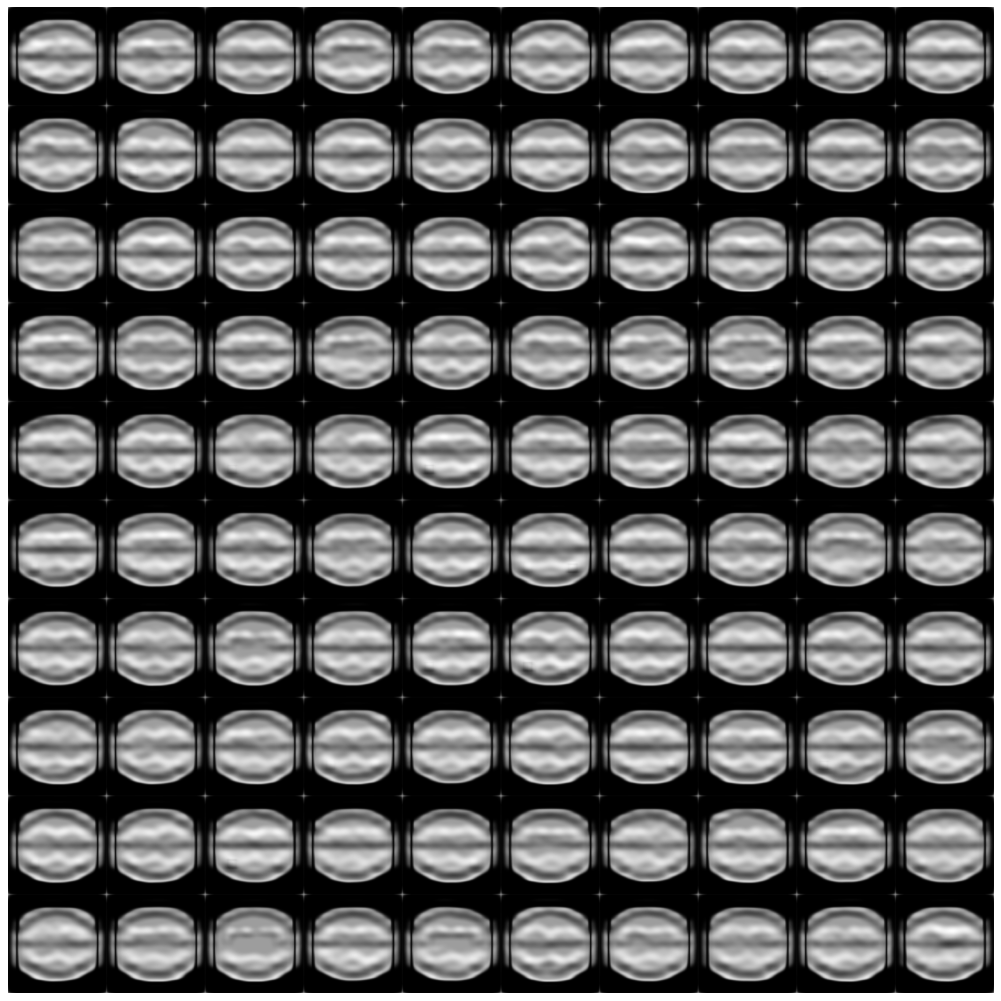

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define grid dimensions
n = 10

# Create an empty placeholder for the images
image_grid = np.empty([210 * n, 210 * n])

model.eval()

# Loop through each grid point
for i in range(n):
    for j in range(n):
        z = torch.randn(batch_size, 64).to(device)

        # Decode the latent point
        with torch.no_grad():
            generated_image = model.decoder(z)

        generated_image = generated_image.cpu().numpy()  # Move the image to CPU and convert to NumPy array
        generated_image = np.squeeze(generated_image)  # Remove singleton dimensions

        # Populate the image grid. The slice sizes should now be 210, not 256.
        image_grid[i * 210:(i + 1) * 210, j * 210:(j + 1) * 210] = generated_image[:1]

plt.figure(figsize=(16, 16), dpi=80)
plt.axis("off")
plt.imshow(image_grid, cmap='gray')
plt.show()
